# Book Babies

## Embedding Calculations

### EEK 2024-10-21

In [1]:
# ! pip install tqdm boto3 requests regex sentencepiece sacremoses
# ! git clone https://github.com/FlagOpen/FlagEmbedding.git
# ! cd FlagEmbedding
# ! pip install -e .
# ! poetry add FlagEmbedding
# ! poetry add peft

In [134]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np
import csv
from tqdm import tqdm

from typing import Dict, Text
import re
import json
import io

# Import necessary modules
import transformers
from FlagEmbedding import BGEM3FlagModel

# Import metrics for ranking 
from sklearn.metrics import mutual_info_score

* Found a spotify dataset on huggingface and I think that's the best kind of V0 - all of the things are well controlled for...
* And song babies is also a fun project :)
* df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

* But for generating embeddings for large text, we've got:
* https://huggingface.co/BAAI/bge-m3


In [4]:
## Embeddings for large text using the BGE-M3 model from huggingface

model = BGEM3FlagModel('BAAI/bge-m3',  
                       use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
# test 

sentences_1 = ["What is BGE M3?", "Defination of BM25"]
sentences_2 = ["BGE M3 is an embedding model supporting dense retrieval, lexical matching and multi-vector interaction.", 
               "BM25 is a bag-of-words retrieval function that ranks a set of documents based on the query terms appearing in each document"]

embeddings_1 = model.encode(sentences_1, 
                            batch_size=12, 
                            max_length=8192, # If you don't need such a long length, you can set a smaller value to speed up the encoding process.
                            )['dense_vecs']
embeddings_2 = model.encode(sentences_2)['dense_vecs']

In [13]:
# how well does it perform? 
similarity = embeddings_1 @ embeddings_2.T
print(similarity)
# [[0.6265, 0.3477], [0.3499, 0.678 ]]

[[0.626  0.3477]
 [0.3499 0.678 ]]


In [241]:
df_raw = pd.read_csv('data/data_cleaned.csv').drop(columns=['Summary_length', 'Unnamed: 0'])

In [242]:
df_raw.shape

(3196, 11)

In [19]:
%%time 
df = df_raw.copy()
df['embed1'] = [model.encode(a, batch_size=12, max_length=8192)['dense_vecs'] for a in df.Summary]

CPU times: user 10min 57s, sys: 6min 46s, total: 17min 43s
Wall time: 13h 1min 41s


In [20]:
print('all done')

all done


In [112]:
df.head(5)

,BookTitle,Author,Summary,genre_list,year_published,avg_rating,std_rating,num_ratings,avg_rating_author,num_ratings_author,num_works,embed1
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...","['Roman à clef', 'Satire', ""Children's literat...",1956.0,8.281910,1.721726,120.0,8.565043,344.0,8,"[-0.00864, 0.03973, -0.02974, -0.01372, -0.030..."
1,The Plague,Albert Camus,The text of The Plague is divided into five p...,"['Existentialism', 'Fiction', 'Absurdist ficti...",1972.0,8.111111,1.166667,9.0,8.039720,107.0,7,"[0.05157, 0.04187, -0.03, -0.02156, 0.01306, -..."
2,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...","['War novel', 'Roman à clef']",1990.0,8.531250,1.413857,32.0,8.391304,46.0,4,"[0.01214, 0.005836, -0.0624, -0.0155, -0.01211..."
3,Crash,J. G. Ballard,The story is told through the eyes of narrato...,"['Speculative fiction', 'Fiction', 'Novel']",1996.0,6.000000,NaN,1.0,7.431818,11.0,17,"[-0.013916, -0.02834, -0.011765, -0.01927, 0.0..."
4,Children of Dune,Frank Herbert,Nine years after Emperor Paul Muad'dib walked...,"['Science Fiction', 'Speculative fiction', ""Ch...",1977.0,8.875000,2.121320,5.0,8.208907,353.0,20,"[0.02283, 0.002647, -0.03833, -0.0379, -0.0370..."


In [26]:
df['embed1'][0].shape

(1024,)

In [245]:
# try crossing Parent 1 and Parent 2

embed_p1 = list(df['embed1'][df.BookTitle=='Timequake'])
embed_p2 = list(df['embed1'][df.BookTitle=='The Wind in the Willows'])

test_embed_mean = np.mean([embed_p1, embed_p2], axis=0)

test_embed_mean.shape

(1, 1024)

In [246]:
embed_p1[0:10]

[array([ 0.00154,  0.02184, -0.01671, ..., -0.05133, -0.03018, -0.0573 ],
       dtype=float16)]

In [247]:
embed_p2[0:10]

[array([ 0.04276 ,  0.03992 , -0.05338 , ..., -0.002136, -0.02936 ,
        -0.01717 ], dtype=float16)]

In [248]:
test_embed_mean

array([[ 0.02214,  0.03088, -0.03503, ..., -0.02673, -0.02977, -0.03723]],
      dtype=float16)

In [249]:
np.dot(embed_p1, np.asarray(embed_p2).T)

array([[0.5044]], dtype=float16)

In [250]:
df_test = df.copy()

In [251]:
df_test['cosine_similarity'] = df_test['embed1'].apply(lambda x: np.dot(x, test_embed_mean.T)[0])

In [253]:
df_test[df_test.num_ratings > 1.0].sort_values(by='cosine_similarity', ascending=False).head(10)

,BookTitle,Author,Summary,genre_list,year_published,avg_rating,std_rating,num_ratings,avg_rating_author,num_ratings_author,num_works,embed1,cosine_similarity
464,Timequake,Kurt Vonnegut,Vonnegut uses the premise of a timequake (or ...,"['Autobiographical novel', 'Time travel', 'Spe...",1997.0,7.459091,1.708786,32.0,8.067276,374.0,15,"[0.00154, 0.02184, -0.01671, 0.0084, -0.02313,...",0.752441
71,The Wind in the Willows,Kenneth Grahame,"At the start of the book, it is spring time: ...","[""Children's literature"", 'Fiction', 'Novel']",1980.0,8.051020,0.959388,18.0,8.305599,39.0,1,"[0.04276, 0.03992, -0.05338, 0.00727, -0.00520...",0.752441
844,Dandelion Wine,Ray Bradbury,Chapter 1 — Spending the night in the cupola ...,"['Science Fiction', 'Novel', 'Speculative fict...",1976.0,8.187500,1.258306,7.0,7.920468,244.0,9,"[-0.014595, 0.02852, -0.0353, -0.02394, -0.000...",0.608887
1236,Tales of a Fourth Grade Nothing,Judy Blume,The novel is a first person account of a nine...,"[""Children's literature"", 'Fiction']",1972.0,8.500000,0.707107,9.0,7.350943,550.0,19,"[-0.00927, 0.02141, -0.01071, -0.00859, -0.006...",0.593750
428,On the Road,Jack Kerouac,The two main characters of the book are the n...,"['Roman à clef', 'Novel', 'Fiction']",1981.0,8.466472,1.472710,58.0,7.618287,207.0,3,"[-0.04684, 0.00585, -0.05347, -0.00644, 0.0074...",0.588867
486,Invisible Man,Ralph Ellison,"In the beginning, the narrator lives in a sma...","['Science Fiction', ""Children's literature"", '...",1972.0,8.586264,1.364139,39.0,8.410093,46.0,2,"[-0.01222, 0.05914, -0.007042, 0.01755, -0.016...",0.587891
983,Ghostwritten,David Mitchell,"This details the actions of Quasar, a member ...",['Novel'],2000.0,7.857143,1.214986,7.0,8.166667,12.0,3,"[-0.01278, -0.02429, -0.0451, 0.0004408, -0.00...",0.586914
387,Breakfast of Champions,Kurt Vonnegut,"Kilgore Trout is a widely published, but othe...","['Science Fiction', 'Speculative fiction', 'Fi...",1991.0,7.628882,1.877020,37.0,8.067276,374.0,15,"[-0.005665, 0.02951, 0.0335, 0.006565, -0.0185...",0.586426
2275,Ghost Story,Peter Straub,The novel opens with a man named Donald Wande...,"['Speculative fiction', 'Horror', 'Fiction']",1979.0,7.583333,1.653205,13.0,6.973515,142.0,7,"[-0.0002449, -0.003752, -0.00467, -0.01805, 0....",0.586426
45,Tunnel in the Sky,Robert A. Heinlein,A Malthusian catastrophe on Earth has been av...,"['Science Fiction', 'Speculative fiction', ""Ch...",1987.0,7.600000,0.547723,5.0,8.123401,362.0,34,"[0.001365, 0.02235, -0.01874, -0.00605, -0.035...",0.585938


<Axes: xlabel='cosine_similarity', ylabel='Count'>

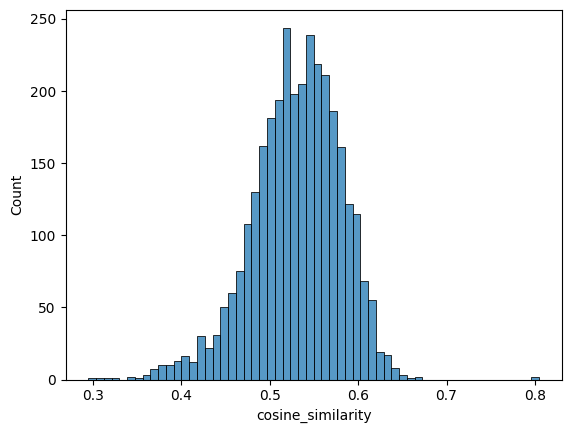

In [107]:
sns.histplot(data=df_test, x='cosine_similarity')

## Cosine similarity is great and a go-to but let's just check to see if other distance metrics might be useful

In [121]:
df_test['l2_distance'] = df_test['embed1'].apply(lambda x: np.linalg.norm(x - test_embed_mean[0]))  # euclidean distance
df_test['l1_distance'] = df_test['embed1'].apply(lambda x: np.linalg.norm(x - test_embed_mean[0], 1)) # manhattan distance

<Axes: xlabel='cosine_similarity', ylabel='l1_distance'>

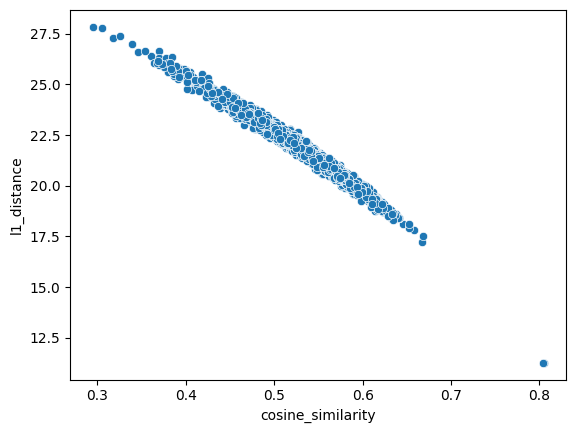

In [122]:
sns.scatterplot(data=df_test, x='cosine_similarity', y='l1_distance')

<Axes: xlabel='l1_distance', ylabel='Count'>

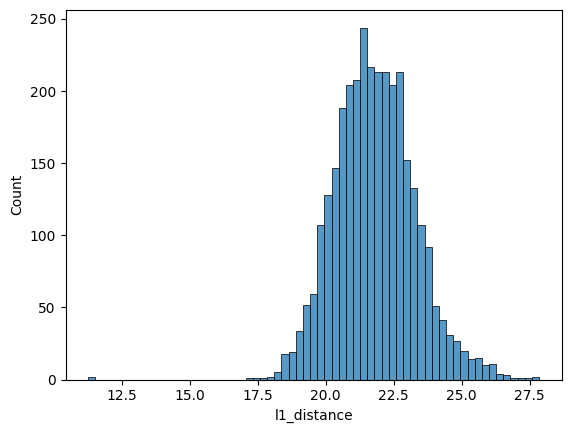

In [123]:
sns.histplot(data=df_test, x='l1_distance')

# Let's visualize this in tensorboard!

In [160]:
df_test['embed_tsv'] = [''.join(list(str(df_test['embed1'][i]))) for i in range(len(df_test))]

In [ ]:
import csv

def write_tsv_iteratively(filename, data):
    """
    Writes data to a TSV file iteratively, line by line.

    Args:
        filename: The name of the TSV file to create.
        data: An iterable of lists or tuples representing rows of data.
    """

    with open(filename, 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t')

        for row in data:
            writer.writerow(row)
  

In [ ]:
write_tsv_iteratively("raw_embeddings.tsv", df_test['embed1'])

In [137]:
df_test['BookTitle'].to_csv('titles.tsv', sep='\t')

In [167]:
df_embeddings = pd.read_csv('raw_embeddings.tsv', sep='\t', header=None)

## Can we compress this from 1024*M to something significantly smaller?

Using PCA can help us compress this data to use it more easily and with a reasonably minor loss in fidelity

In [168]:
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.008640,0.039730,-0.029740,-0.01372,-0.030470,-0.037960,0.001379,0.017610,-0.010925,-0.003704,...,0.02159,0.023100,0.050380,0.03174,0.003107,0.014160,0.035950,0.008354,-0.041560,-0.016270
1,0.051570,0.041870,-0.030000,-0.02156,0.013060,-0.053200,-0.025040,0.002455,0.012470,0.033230,...,0.00903,0.009030,0.027340,0.03062,-0.023030,-0.002676,-0.010180,-0.012230,-0.020110,-0.023540
2,0.012140,0.005836,-0.062400,-0.01550,-0.012115,-0.016270,0.079400,-0.011570,0.023210,0.042570,...,-0.00869,0.044460,0.012505,0.03665,-0.032560,-0.008870,-0.007626,0.017670,-0.019360,0.011140
3,-0.013916,-0.028340,-0.011765,-0.01927,0.007740,0.006165,0.004050,-0.022100,0.010090,0.009544,...,-0.01339,0.048580,0.028610,0.04373,-0.029980,-0.008170,-0.026800,0.021300,0.004368,0.016070
4,0.022830,0.002647,-0.038330,-0.03790,-0.037080,-0.023040,-0.000899,0.009480,0.001187,0.026690,...,-0.00934,0.001112,0.048770,0.01526,-0.002321,-0.019500,-0.000202,0.033400,-0.011180,0.011086


In [169]:
from sklearn.decomposition import PCA

In [235]:
# First it's useful to see what the maximal PCA scree plot would look like, so that is shown below and an elbow is chosen

In [189]:
pca_test = PCA(n_components=1024)
pca_test.fit(df_embeddings)

PCA(n_components=1024)

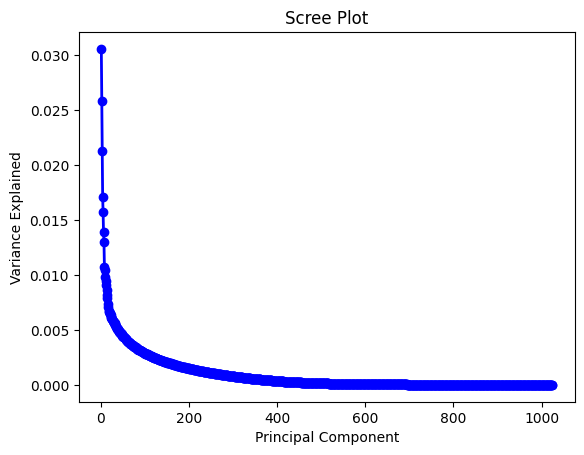

In [190]:
PC_values = np.arange(pca_test.n_components_) + 1
plt.plot(PC_values, pca_test.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [191]:
pca_test.explained_variance_ratio_

array([3.05357598e-02, 2.57686354e-02, 2.12823669e-02, ...,
       2.09336162e-06, 1.94795855e-06, 1.53575407e-09])

In [236]:
sum(pca_test.explained_variance_ratio_[0:199]) # how much variance is explained using the first 200 components?
# we are going to call this reasonable, we'll call the elbow 200.  I like numbers around 80%

0.7890199861472981

In [238]:

# and now we run it again for the number of components we actually want, 
# and do the transformation which reduces the size of each vector 
# from 1024 to 200, a roughly 80% savings for about a 20% loss in fidelity


In [194]:
pca = PCA(n_components=200)

In [199]:
df_embeddings_pca = pca.fit_transform(df_embeddings)

In [196]:
df_embeddings_pca.shape

(3196, 200)

In [200]:
write_tsv_iteratively("pca_embeddings.tsv", df_embeddings_pca)

In [ ]:
# Now let's also have some metadata to help us in the visualization

In [231]:
df_meta = df[['BookTitle', 'Author', 'genre_list', 'year_published', 'avg_rating', 'num_ratings', 'num_works']]
df_meta.head()

,BookTitle,Author,genre_list,year_published,avg_rating,num_ratings,num_works
0,Animal Farm,George Orwell,"['Roman à clef', 'Satire', ""Children's literat...",1956.0,8.281910,120.0,8
1,The Plague,Albert Camus,"['Existentialism', 'Fiction', 'Absurdist ficti...",1972.0,8.111111,9.0,7
2,All Quiet on the Western Front,Erich Maria Remarque,"['War novel', 'Roman à clef']",1990.0,8.531250,32.0,4
3,Crash,J. G. Ballard,"['Speculative fiction', 'Fiction', 'Novel']",1996.0,6.000000,1.0,17
4,Children of Dune,Frank Herbert,"['Science Fiction', 'Speculative fiction', ""Ch...",1977.0,8.875000,5.0,20


In [234]:
df_meta.to_csv('df_meta.tsv', sep='\t', index=False)

In [287]:
df['embed1'][0:10]

0    [-0.00864, 0.03973, -0.02974, -0.01372, -0.030...
1    [0.05157, 0.04187, -0.03, -0.02156, 0.01306, -...
2    [0.01214, 0.005836, -0.0624, -0.0155, -0.01211...
3    [-0.013916, -0.02834, -0.011765, -0.01927, 0.0...
4    [0.02283, 0.002647, -0.03833, -0.0379, -0.0370...
5    [0.01672, 0.003742, -0.02943, 0.01657, -0.0045...
6    [0.01027, 0.03647, -0.01665, 0.004025, 0.00066...
7    [-0.00894, 0.04645, -0.04837, -0.005363, -0.01...
8    [0.05127, 0.03854, -0.04428, -0.00227, -0.0065...
9    [-0.0005527, 0.0491, -0.0467, 0.01747, -0.0303...
Name: embed1, dtype: object

In [369]:
df['embed_pca'] = [np.array(df_pca[i]) for i in range(len(df_pca))] #_full.apply(lambda row: np.array(row), axis=1).reshape([1, 1024])  #.to_numpy().to_list() #.apply(lambda row: np.array(','.join(row.astype(str))), axis=1)


In [370]:
type(df['embed_pca'][0])

numpy.ndarray

In [372]:
df.drop(['combined', 'Summary'], axis=1, inplace=True)

In [412]:
# Let's try some new genetic pairings - we'll make a function for ease

# inputs - the parent book titles, the column name of the embedding, the method, and if the top N results are shown.
# granularity will be added later.

def genetic_pairing(df, 
                    parent1_title = 'Timequake', 
                    parent2_title ='The Wind in the Willows' , 
                    embedding_colname = 'embeddings', 
                    similarity_colname = 'cosine_similarity',
                    method='mean', 
                    display_topN = True, 
                    N=5, 
                    return_embeddings = False,
                    granularity=None):

    df_temp = df.copy()
    assert ((method == 'genetic' and granularity != None) or method != 'genetic')

    parent1_embeddings = list(df_temp[embedding_colname][df_temp.BookTitle==parent1_title])
    parent2_embeddings = list(df_temp[embedding_colname][df_temp.BookTitle==parent2_title])
    
    if method == 'mean':
        baby_embeddings = np.mean([parent1_embeddings, parent2_embeddings], axis=0)


    if display_topN:
        df_temp['cosine_similarity'] = df_temp[embedding_colname].apply(lambda x: np.dot(x, baby_embeddings.T)[0])
    
    display(df_temp.sort_values(by='cosine_similarity', ascending=False).head(N))
        
    if return_embeddings:
        return baby_embeddings

        

In [419]:
genetic_pairing(df, 'Timequake', 'The Wind in the Willows', 'embed1', display_topN=True, N=10)

,BookTitle,Author,genre_list,year_published,avg_rating,std_rating,num_ratings,avg_rating_author,num_ratings_author,num_works,embed1,embed_pca,cosine_similarity
71,The Wind in the Willows,Kenneth Grahame,"[""Children's literature"", 'Fiction', 'Novel']",1980.0,8.051020,0.959388,18.0,8.305599,39.0,1,"[0.04276, 0.03992, -0.05338, 0.00727, -0.00520...","[-0.17013909894785928, -0.1086692584353887, -0...",0.752441
464,Timequake,Kurt Vonnegut,"['Autobiographical novel', 'Time travel', 'Spe...",1997.0,7.459091,1.708786,32.0,8.067276,374.0,15,"[0.00154, 0.02184, -0.01671, 0.0084, -0.02313,...","[0.014253699355832204, 0.10001623837565377, 0....",0.752441
2327,The Animals of Farthing Wood,Colin Dann,"[""Children's literature"", 'Fantasy', 'Speculat...",1989.0,8.000000,NaN,1.0,6.000000,2.0,7,"[0.018, 0.01865, -0.0681, -0.02365, -0.011444,...","[-0.2521696406154328, -0.06816990330429193, -0...",0.641602
844,Dandelion Wine,Ray Bradbury,"['Science Fiction', 'Novel', 'Speculative fict...",1976.0,8.187500,1.258306,7.0,7.920468,244.0,9,"[-0.014595, 0.02852, -0.0353, -0.02394, -0.000...","[-0.19250910780587585, -0.11301343576045032, -...",0.608887
1236,Tales of a Fourth Grade Nothing,Judy Blume,"[""Children's literature"", 'Fiction']",1972.0,8.500000,0.707107,9.0,7.350943,550.0,19,"[-0.00927, 0.02141, -0.01071, -0.00859, -0.006...","[-0.09297507026978376, -0.13518751215412853, -...",0.593750
1511,The Incredible Journey,Sheila Burnford,"['Drama', 'Adventure']",1990.0,9.000000,NaN,1.0,9.000000,1.0,1,"[-0.03488, -0.01826, -0.0572, -0.0174, -0.0171...","[-0.15242786919333878, -0.05455842773628143, -...",0.592773
428,On the Road,Jack Kerouac,"['Roman à clef', 'Novel', 'Fiction']",1981.0,8.466472,1.472710,58.0,7.618287,207.0,3,"[-0.04684, 0.00585, -0.05347, -0.00644, 0.0074...","[0.02573181168834971, -0.059554472604476154, -...",0.588867
486,Invisible Man,Ralph Ellison,"['Science Fiction', ""Children's literature"", '...",1972.0,8.586264,1.364139,39.0,8.410093,46.0,2,"[-0.01222, 0.05914, -0.007042, 0.01755, -0.016...","[-0.052209045122424, -0.046163181106724085, 0....",0.587891
983,Ghostwritten,David Mitchell,['Novel'],2000.0,7.857143,1.214986,7.0,8.166667,12.0,3,"[-0.01278, -0.02429, -0.0451, 0.0004408, -0.00...","[-0.17956816003840612, 0.06411761191439044, 0....",0.586914
2033,Amongst Women,John McGahern,"['Fiction', 'Novel']",1995.0,8.000000,NaN,1.0,6.750000,4.0,2,"[0.005825, 0.01862, -0.05362, -0.02718, -0.016...","[-0.017897937300754858, -0.05490836910649265, ...",0.586914
